In [1]:
# imports
import numpy as np
import krakenex as k
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from pathlib import Path
import sys
from datetime import datetime, timedelta
from matplotlib import dates 
from sqlalchemy import create_engine, MetaData, Table, Column, DateTime, Float, String,Integer

dbInstance = 'sqlite:///krakenTeader.db'
dbBalanceHistoryTable = 'BalanceHistory'
dbTradesHistoryTable = 'TradesHistory'
engine = create_engine(dbInstance)


In [2]:


#preparar datos para plotear
BalanceHistory = pd.read_sql(dbBalanceHistoryTable, con=engine)
BalanceHistory = BalanceHistory.set_index(pd.DatetimeIndex(BalanceHistory['Time']))
BalanceHistory.drop('Time', axis=1,inplace=True)

#filtrar periodo de interes
windowTime = 24 
EndSampleTime = datetime(2017,10,4,23,0)
plotmin = True
HoursInterval = 1
if windowTime > 6: plotmin = False
if windowTime > 40: HoursInterval = 2
if windowTime > 60: HoursInterval = 3
if windowTime > 80: HoursInterval = 4

verUltimo=True

if verUltimo:
    startSampleTime = datetime.now() + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[BalanceHistory.index > startSampleTime]
else:
    startSampleTime = EndSampleTime + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[(BalanceHistory.index >= startSampleTime) & (BalanceHistory.index <= EndSampleTime)]

#combertir el balance a un porcentaje entre -100% y 100%
BalanceHistory['balanceRatio'] = (BalanceHistory['balanceRatio'] - 0.5 )*2*100 

BalanceHistory['volbuy'] = BalanceHistory['volbuy'] / BalanceHistory['close']
BalanceHistory['volsell'] = BalanceHistory['volsell'] / BalanceHistory['close']
BalanceHistory['unbalance'] = BalanceHistory['unbalance'] / BalanceHistory['close']

#calcular %CH, %CH Acum , SMA %CH Acum
BalanceHistory['change'] = BalanceHistory['close'].pct_change(periods=1)*100
#BalanceHistory['cahnge2'] = BalanceHistory['close'] / BalanceHistory['close'].shift(1) -1 #equibalente 
BalanceHistory['cum_change'] = BalanceHistory['change'].cumsum()
BalanceHistory['SMA03_cum_change'] = BalanceHistory['cum_change'].rolling(5).mean()
BalanceHistory['SMA12_cum_change'] = BalanceHistory['cum_change'].rolling(12).mean()

#calcular sma de 3 periodos (suavisar el grafico)
BalanceHistory['EWM_unbalance'] =  BalanceHistory["unbalance"].ewm(span=3).mean()

#calcular la porsiocn negativa (para mostrar en rojo en el grafico)
BalanceHistory['EWM_unbalance_N'] = BalanceHistory['EWM_unbalance']
neg = BalanceHistory['EWM_unbalance_N']
neg[neg >= 0] = np.nan
BalanceHistory['EWM_unbalance_N'] = neg

In [3]:
def Condensatetrades():
    
    tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
    tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)

    tradesCondensation =  pd.DataFrame(columns=['time','price','countb','volb','counts','vols'])

    if (len(tradesHistory) > 0) & (len(BalanceHistory) > 0):
        for i in range(len(BalanceHistory)):
            if i > 0:
                t0 = BalanceHistory.index[i]
                t1 = BalanceHistory.index[i-1]

                trades0 = tradesHistory[t1:t0]

                trades0b = trades0[trades0['buy_sell'] =='b']
                trades0s = trades0[trades0['buy_sell'] =='s']

                tradesCountb = len(trades0b)
                tradesCounts = len(trades0s)*-1

                price = trades0.price.mean()

                volb = trades0b.volume.sum()
                vols = trades0s.volume.sum()*-1

                new = [t0,price,tradesCountb,volb,tradesCounts,vols]
                tradesCondensation.loc[len(tradesCondensation)] = new
        #end for
        if (len(tradesCondensation) > 0):
            tradesCondensation.fillna(0,inplace=True)
            tradesCondensation.set_index(pd.DatetimeIndex(tradesCondensation['time']),inplace=True)
            tradesCondensation.drop('time',inplace=True,axis=1)

    return tradesCondensation

In [4]:
#parametros de operaciones
chOpen = 0.3
chClose = 1.5
mbOpen = 0.3

comCompra = 0.29  
comVenta = 0.19 
spreadEntrada = 0.2 
spreadSalida = 0.2
deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

deltaCHObjetivo = 2.5
deltaTargetCH = deltaBaseCH + deltaCHObjetivo
deltaStopLose = deltaBaseCH - chClose
deltaTotalLoseCH = 1
inBase = False
waitPeriods = 60 
waitFactor = 9


def upTrend (df):
    s = df['unbalance']
    sma03 = df['SMA03_cum_change']
    sma12 = df['SMA12_cum_change']
    ch = df['change']
    openPos = 0
    isOpen = False
    inBase = False
    
    sOpenCond = ""
    sCloseCond = ""
        
    #valores de cada operacion 
    openingCH = 0.0
    baseCH = 0.0
    targetCH = 0.0
    stopLoseCH = 0.0
    TotalLoseCH = 0.0
    closingCH = 0.0
    deltaCH = 0.0
    idTrade = 0
    openTime = datetime.now()
    closeTime =openTime

    cols = ['id','openTime','closeTime','tradeDescription','openingCH','baseCH','targetCH','stopLoseCH','TotalLoseCH','closingCH','deltaCH'] 
    myTrades = pd.DataFrame(columns=cols)
   
    for i in range(len(s)):
        if i > 12:
            if (isOpen == False):
                if (s[i] > 0) & (s[i-1] < 0):
                    if (sma03[i] > sma03[i-1]+ chOpen):# & (sma03[i-1] > sma03[i-2] + chOpen):
                        isOpen = True
                        sOpenCond = "MB UP 1"                
                elif (s[i] > 0) & (s[i] > mbOpen):
                    #if (sma03[i] > sma03[i-1]+ chOpen):# & (sma03[i-1] > sma03[i-2] + chOpen):
                    isOpen = True
                    sOpenCond = "MB UP 2"                
                elif (s[i] < 0) & (s[i-1] > s[i-2] + mbOpen*2):
                    #if (sma03[i] > sma03[i-1]+ chOpen):# & (sma03[i-1] > sma03[i-2] + chOpen):
                    isOpen = True
                    sOpenCond = "MB UP 3"                
                
                elif ((sma03[i-1] < sma12[i-1]) & (sma03[i] > sma12[i])): 
                    if (sma03[i] > sma03[i-1]+ chOpen):# & (sma03[i-1] > sma03[i-2] + chOpen):
                        isOpen = True
                        sOpenCond = "SMA03 UP"
                elif (ch[i] > ch[i-1] + chOpen): 
                    if (sma03[i] > sma03[i-1]+ chOpen):# & (sma03[i-1] > sma03[i-2] + chOpen):
                        isOpen = True
                        sOpenCond = "CH UP"
                
                if isOpen == True:
                    #resO.append(s.index[i])
                    openPos = i
                    idTrade = idTrade + 1
                    sDesc = '({0}) ─► {1}'.format(idTrade, sOpenCond)
                    inBase = False
                    openTime = s.index[i]
                    openingCH = df.cum_change[i]
                    baseCH = openingCH + deltaBaseCH
                    targetCH = openingCH + deltaTargetCH
                    stopLoseCH = openingCH + deltaStopLose
                    TotalLoseCH = openingCH - deltaTotalLoseCH
                    
            
            if (isOpen == True):
                if df.cum_change[i] >= baseCH: #nivel de perdidas operacionales superado
                    inBase = True
                
                if inBase == True: 
                    if df.cum_change[i] >= targetCH: #objetivo cumplido
                        if s[i] < mbOpen: #dejar correr las ganancias
                            isOpen = False
                            sCloseCond = "TARGET ACCOMPLISHED AT {0} %CH".format(round(deltaTargetCH,2))
                        
                    if df.cum_change[i] <= (stopLoseCH): #cierre por stop lose
                        isOpen = False
                        sCloseCond = "STOP LOSE AT {0} %CH".format(round(deltaStopLose,2))
                    elif (i >= (openPos + waitPeriods*waitFactor)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | IN BASE".format(waitPeriods*waitFactor)
                        '''
                        if ((sma03[i-1] > sma12[i-1]) & (sma03[i] <= sma12[i])): #cierre por sma corta sma larga
                            isOpen = False
                            sCloseCond = "SMA03 DOWN"
                        '''
                else: #nivel de perdidas operacionales no se logro 
                    if (s[i] <= 0) &(df.cum_change[i] < TotalLoseCH): #cierre por perdida total
                        isOpen = False
                        sCloseCond = "TOTAL LOSE"
                    elif (i >= (openPos + waitPeriods*waitFactor)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | OUT BASE".format(waitPeriods*waitFactor)
                        
                if isOpen == False:
                    #resC.append(s.index[i])
                    sDesc = sDesc + ' | {0}'.format(sCloseCond)
                    #resDesc.append(sDesc)
                    inBase = False
                    
                    #v2
                    closeTime = s.index[i]
                    closingCH = df.cum_change[i]
                    if openingCH >= closingCH:
                        deltaCH = closingCH - openingCH
                    else:
                        deltaCH = closingCH - openingCH
                    newTrade = [idTrade,openTime,closeTime,sDesc,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH]
                    myTrades.loc[len(myTrades)] = newTrade   
                    #fin v2
                    
            if (i == len(s)) & (isOpen == True): #ultima posision y algun trade sigue abierto
                sDesc = sDesc + ' | IN PROGRESS'
                closeTime = s.index[i]
                closingCH = df.cum_change[i]
                if openingCH >= closingCH:
                    deltaCH = closingCH - openingCH
                else:
                    deltaCH = closingCH - openingCH
                newTrade = [idTrade,openTime,closeTime,sDesc,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH]
                myTrades.loc[len(myTrades)] = newTrade
    
    print('Total Trades: {0}'.format(len(myTrades)))
    myTrades.set_index('id',inplace=True)
    return myTrades

Total Trades: 4


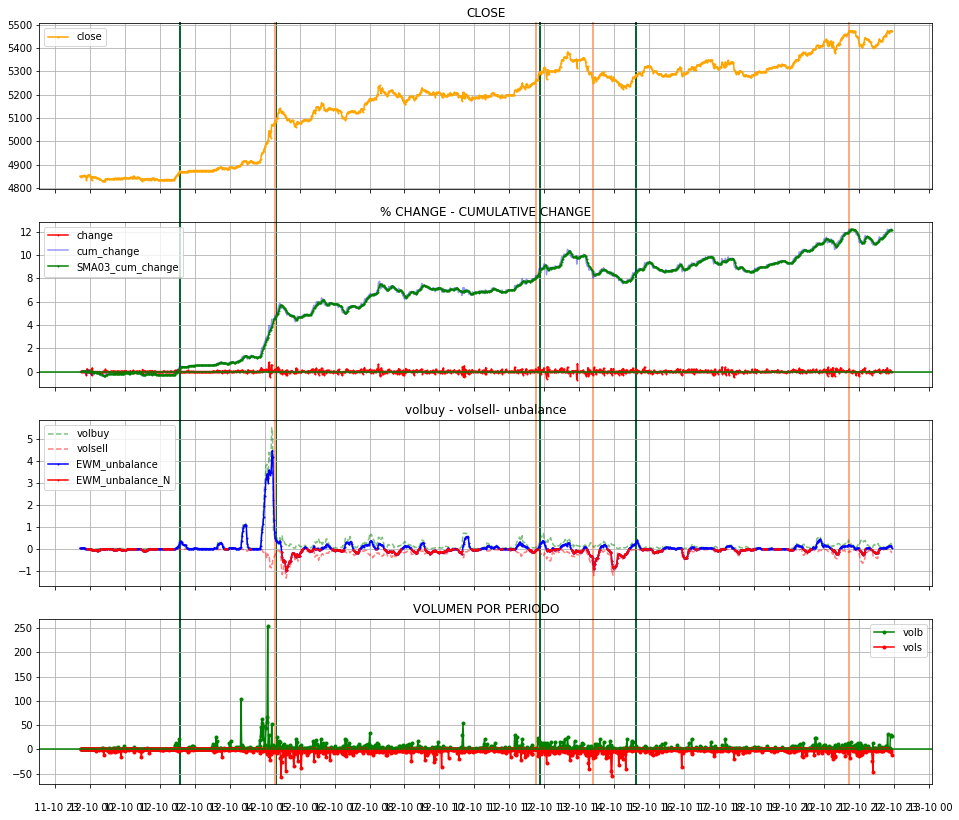

In [5]:
fig,ax = plt.subplots( sharex=True, figsize=(16,14), nrows=4, ncols=1)

#plot price
ax[0].plot_date(BalanceHistory.index, BalanceHistory['close'],'orange',marker='o', markersize=1)
ax[0].yaxis.grid(True) 
ax[0].xaxis.grid(True) 
ax[0].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
ax[0].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
if plotmin ==True:
    ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
    ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
    ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    
ax[0].set_title('CLOSE')
ax[0].legend(loc='best')

#plot %CH short SMA Large SMA
ax[1].plot_date(BalanceHistory.index, BalanceHistory['change'],'ro-', markersize=1)
ax[1].plot_date(BalanceHistory.index, BalanceHistory['cum_change'],'b-',alpha=0.4)
ax[1].plot_date(BalanceHistory.index, BalanceHistory['SMA03_cum_change'],'go-', markersize=1) #ligthBlue
ax[1].yaxis.grid(True) 
ax[1].xaxis.grid(True) 
ax[1].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
ax[1].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
if plotmin ==True:
    ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
    ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
    ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    
ax[1].set_title('% CHANGE - CUMULATIVE CHANGE')
ax[1].legend(loc='best')
ax[1].axhline(0,color='g',ls='-')

#plot  MarquetBalance
ax[2].plot_date(BalanceHistory.index, BalanceHistory['volbuy'],'g--',alpha=0.5)
ax[2].plot_date(BalanceHistory.index, BalanceHistory['volsell'],'r--',alpha=0.5) 
#ax[2].plot_date(BalanceHistory.index, BalanceHistory['unbalance'],'bo-', markersize=3)
ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance'],'bo-', markersize=1)
ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance_N'],'ro-', markersize=1)

ax[2].yaxis.grid(True) 
ax[2].xaxis.grid(True) 
ax[2].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
ax[2].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
if plotmin ==True:
    ax[2].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
    ax[2].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
    ax[2].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    
ax[2].set_title('volbuy - volsell- unbalance')
ax[2].legend(loc='best')
#ax[2].axhline(0,color='g',ls='-')

tradesCondensation = Condensatetrades()

# plot count
ax[3].plot_date(tradesCondensation.index, tradesCondensation['volb'],'g',marker='o', markersize=3)
ax[3].plot_date(tradesCondensation.index, tradesCondensation['vols'],'r',marker='o', markersize=3)
ax[3].yaxis.grid(True) 
ax[3].xaxis.grid(True) 
ax[3].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
ax[3].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
if plotmin ==True:
    ax[3].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
    ax[3].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
    ax[3].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

ax[3].set_title('VOLUMEN POR PERIODO')
ax[3].legend(loc='best')
ax[3].axhline(0,color='g',ls='-')


myTrades = upTrend(BalanceHistory)

for d in  myTrades.openTime:
    ax[0].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
    ax[1].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
    ax[2].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
    ax[3].axvline(d,ymin=0,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
    
for d in myTrades.closeTime:
    ax[0].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
    ax[1].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
    ax[2].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
    ax[3].axvline(d,ymin=0,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
    


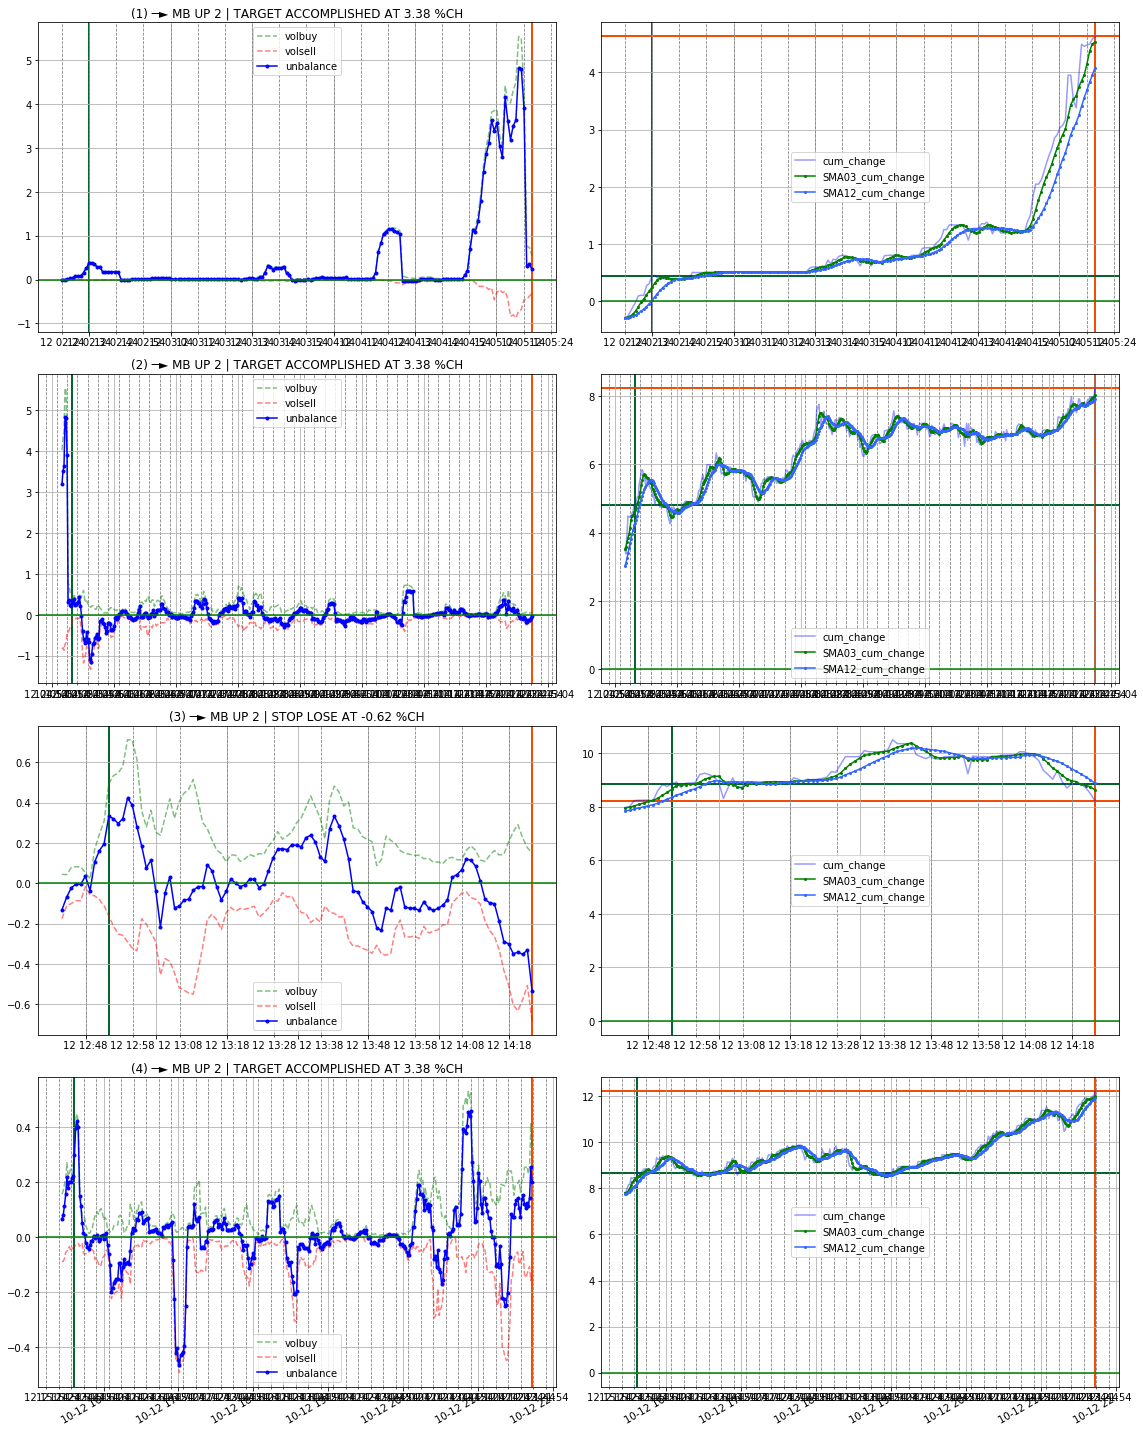

In [6]:
def plotAllTrades():
    tradesCount = len(myTrades)
    if tradesCount > 0:
        fig, axes = plt.subplots(tradesCount, 2, figsize=(16,tradesCount*5))
        for i in range(tradesCount):
            n = i+1
            row = axes[i]
            dOpen = myTrades.openTime[n]
            iniPos = BalanceHistory.index.get_loc(dOpen)-10
            iniMoment = BalanceHistory.index[iniPos] 

            sDesc = myTrades.tradeDescription[n]
            if i  < tradesCount:
                dClose = myTrades.closeTime[n]
                endPos = BalanceHistory.index.get_loc(dClose)+0
                endMoment = BalanceHistory.index[endPos] 
            else:
                dClose = BalanceHistory.index.max()
                endMoment = BalanceHistory.index.max()

            df =  BalanceHistory[(BalanceHistory.index >= iniMoment) & (BalanceHistory.index <= endMoment)]

            #calcular %CH, %CH Acum , SMA %CH Acum
            #df['change'] = df['close'].pct_change(periods=1)*100
            #df['cum_change'] = df['change'].cumsum()
            #df['SMA03_cum_change'] = df['cum_change'].rolling(3).mean()
            #df['SMA12_cum_change'] = df['cum_change'].rolling(12).mean()
            plotTrade(row, df,dOpen, dClose, sDesc,myTrades.openingCH[n],myTrades.closingCH[n])

        fig.autofmt_xdate() 
        plt.legend() 
        plt.tight_layout() 
        plt.show()
    else:
        print('No trades for plot')

def plotTrade(ax, df, dOpen, dClose, sDesc, openCH,closeCH):
    ax[0].plot_date(df.index, df['volbuy'],'g--',alpha=0.5)
    ax[0].plot_date(df.index, df['volsell'],'r--',alpha=0.5)
    ax[0].plot_date(df.index, df['unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance_N'],'ro-', markersize=3)
    ax[0].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[0].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=10)) 
    ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%d %H:%M'))
    ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    ax[0].legend(loc='best')
    ax[0].axhline(0,color='g',ls='-')
    ax[0].set_title(sDesc)

    ax[1].plot_date(df.index, df['cum_change'],'b-',alpha=0.4)
    ax[1].plot_date(df.index, df['SMA03_cum_change'],'go-', markersize=2)
    ax[1].plot_date(df.index, df['SMA12_cum_change'],'o-',color='#3366ff', markersize=2) #ligthBlue
    ax[1].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].axhline(openCH,xmin=-0,xmax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axhline(closeCH,xmin=-0,xmax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=10)) 
    ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%d %H:%M'))
    ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='g',ls='-')
    
plotAllTrades()

In [7]:
deltaVol = tradesCondensation['volb'].sum() + tradesCondensation['vols'].sum()
deltaVol

870.07646789000046

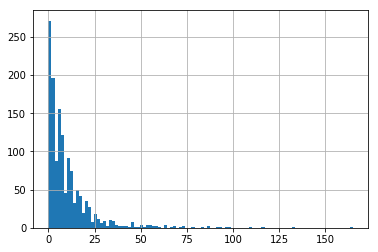

In [8]:
tradesCondensation['countb'].hist(bins=100)

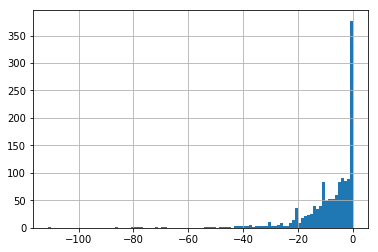

In [9]:
tradesCondensation['counts'].hist(bins=100)

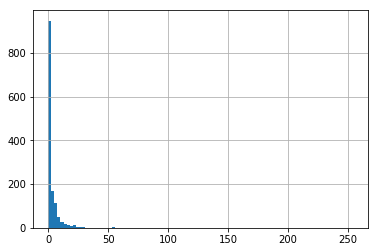

In [10]:
tradesCondensation['volb'].hist(bins=100)

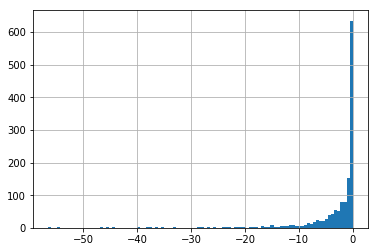

In [11]:
tradesCondensation['vols'].hist(bins=100)

totalWin: 10.505555067454646, totalCom: 3.5199999999999996, finalBalance: 6.985555067454646


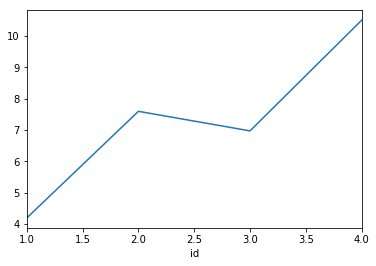

In [14]:
myTrades['Profit'] = myTrades['deltaCH'].cumsum()
myTrades['Profit'].plot()
totalCom = len(myTrades) * deltaBaseCH
totalWin = myTrades.deltaCH.sum()
finalBalance = totalWin - totalCom
print('totalWin: {0}, totalCom: {1}, finalBalance: {2}'.format(totalWin,totalCom,finalBalance))

In [13]:
myTrades

,openTime,closeTime,tradeDescription,openingCH,baseCH,targetCH,stopLoseCH,TotalLoseCH,closingCH,deltaCH,Profit
id,,,,,,,,,,,
1,2017-10-12 02:33:56.879718,2017-10-12 05:17:06.583312,(1) ─► MB UP 2 | TARGET ACCOMPLISHED AT 3.38 %CH,0.435830,1.315830,3.815830,-0.184170,-0.564170,4.623713,4.187882,4.187882
2,2017-10-12 05:19:07.218324,2017-10-12 12:44:59.315314,(2) ─► MB UP 2 | TARGET ACCOMPLISHED AT 3.38 %CH,4.824547,5.704547,8.204547,4.204547,3.824547,8.231387,3.406840,7.594722
3,2017-10-12 12:52:56.067751,2017-10-12 14:22:47.764821,(3) ─► MB UP 2 | STOP LOSE AT -0.62 %CH,8.847976,9.727976,12.227976,8.227976,7.847976,8.222986,-0.624989,6.969733
4,2017-10-12 15:36:42.894978,2017-10-12 21:42:59.558378,(4) ─► MB UP 2 | TARGET ACCOMPLISHED AT 3.38 %CH,8.680924,9.560924,12.060924,8.060924,7.680924,12.216746,3.535822,10.505555
